### Lets try to implement the gaussian type STO-3G basis set. It is the most simple and hence should be relatively easier to implement 
- The choice of basis (and its size) is quite important especially for the two electron integrals. 
- The number of two electron integrals increases as N$^4$ where N is the basis set size. 
- The HF-limit can only be achieved with a complete basis (infinite basis set size). However, that is not possible even using the high-power supercomputing facilities available today. The basic issues are the computation of integrals and the memory required to store the N$^4$ integrals.


Firstly, comparing the Hydrogenic 1s, Slater 1s and and STO-3G 1s orbital to see the difference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def slater_1s(r, epsilon):
    return (epsilon**3/np.pi)*np.exp(-1*epsilon*r)
def hydrogen_1s(r):
    a0 = 0.529
    return (1/np.pi)*((1/a0)**(3/2))*np.exp(-1*r/a0)
def gaussian(r, alpha):
    return ((2*alpha/np.pi)**(3/4))*np.exp(-1*alpha*r**2)
def gaussian_1s_sto_3g(r, R):
    c1=0.444635
    c2=0.535328
    c3=0.154329
    return c1*gaussian(r, 0.109)+c2*gaussian(r, 0.405)+c3*gaussian(r, 2.227)
    


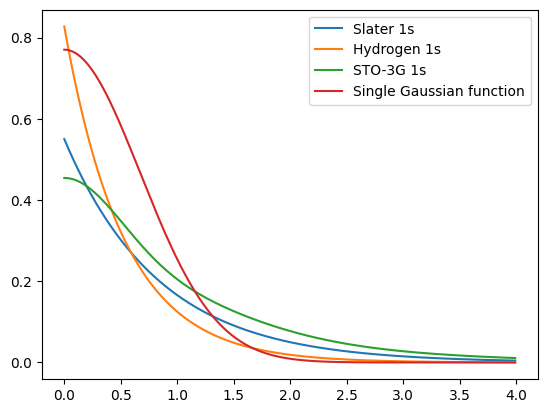

In [2]:
r = np.arange(0,4,0.01)
fig = plt.figure()
plt.plot(r ,slater_1s(r, 1.2), label='Slater 1s')
plt.plot(r, hydrogen_1s(r), label='Hydrogen 1s')
plt.plot(r, gaussian_1s_sto_3g(r, 0), label='STO-3G 1s')
plt.plot(r, gaussian(r, 1.109), label='Single Gaussian function')
# plt.xlim((0,0.6))
plt.legend()
plt.show()


## lets make a function to compute the overlap integral given two basis set functions (using Szabo Ostlund example)

In [6]:
def gaussian_from_vectors(r, R, alpha):
    import numpy as np
    r = np.array(r)
    R = np.array(R)
    diff_norm = np.linalg.norm(r-R) 
    return ((2*alpha/np.pi)**(3/4))*np.exp(-1*alpha*diff_norm**2)

def gaussian_from_scalars(r, R, alpha):
    import numpy as np
    diff = r-R
    return ((2*alpha/np.pi)**(3/4))*np.exp(-1*alpha*diff**2), r, R, alpha
    

In [7]:
print(gaussian_from_vectors([1,1,1], [1,1,1], 1.109))
print(gaussian_from_scalars(1,1,1.109))

0.7702092885990075
(0.7702092885990075, 1, 1, 1.109)


In [8]:
## this is a function which takes two gaussian functions with scalars and integrates them

In [9]:
def gaussian_1s_sto_3g(r, R):
    import numpy as np
    r = np.array(r)
    R = np.array(R)
    c1=0.444635
    c2=0.535328
    c3=0.154329
    alpha_1 = 0.109
    alpha_2 = 0.405
    alpha_3 = 2.227
    basis = c1*gaussian_from_vectors(r, R, alpha_1)+c2*gaussian_from_vectors(r, R, alpha_2)
    +c3*gaussian_from_vectors(r, R, alpha_3)
    return basis, r, R, [c1, c2, c3], [alpha_1, alpha_2, alpha_3]

In [10]:
print(gaussian_1s_sto_3g([1,1,1],[1,1,1]))

(0.25381140262972013, array([1, 1, 1]), array([1, 1, 1]), [0.444635, 0.535328, 0.154329], [0.109, 0.405, 2.227])


In [13]:
def integrate_two_primitve_gaussian_on_two_centers(alpha,beta,R_A,R_B):
    p = alpha+beta
    R_A = np.array(R_A)
    R_B = np.array(R_B)
    diff_norm = np.linalg.norm(R_A-R_B)
#     integral = ((2*alpha*beta/(p*np.pi))**(3/4))*((np.pi/p)**(3/2))*np.exp((-1*alpha*beta/p)*(diff_norm)**2)
    integral = ((np.pi/p)**(3/2))*np.exp((-1*alpha*beta/p)*(diff_norm)**2)
    return integral

In [14]:
print(integrate_two_primitve_gaussian_on_two_centers(0.109,0.109,[0,0,0],[0,0,0]))

54.70664337026415


In [20]:
basis_info = gaussian_1s_sto_3g([0,0,0], [0,0,0])
print(basis_info)

(0.25381140262972013, array([0, 0, 0]), array([0, 0, 0]), [0.444635, 0.535328, 0.154329], [0.109, 0.405, 2.227])


In [23]:
overlap_mat_element=0
for i in range(len(basis_info[3])):
    for j in range(len(basis_info[3])):
        alpha = basis_info[4][i]
        beta = basis_info[4][j]
        R_A = basis_info[2]
        R_B = basis_info[2]
        integral = basis_info[3][i]*basis_info[3][j]*integrate_two_primitve_gaussian_on_two_centers(alpha, beta, R_A, R_B)
        overlap_mat_element+=integral

In [24]:
print(overlap_mat_element)

2.2613716558203736


In [4]:
## not sure what this is!! Wrote this part of the code loong time ago. I am guessing that use of sympy is to compute the 
## derivatives and kinetic energy part of the fock operator

import sympy as sp

# Define symbols
x, y, z, alpha, hbar, m = sp.symbols('x y z alpha hbar m', real=True, positive=True)
A = sp.symbols('A', real=True)  # Amplitude, if normalization is required

# Define the Gaussian wavefunction
r_squared = x**2 + y**2 + z**2
psi = A * sp.exp(-alpha * r_squared)

# Compute the Laplacian of the wavefunction
laplacian_psi = sp.diff(psi, x, 2) + sp.diff(psi, y, 2) + sp.diff(psi, z, 2)

# Define the kinetic energy operator
kinetic_energy_operator = -(hbar**2 / (2 * m)) * laplacian_psi

# Compute the kinetic energy integral
integrand = sp.conjugate(psi) * kinetic_energy_operator
kinetic_energy_integral = sp.integrate(integrand, (x, 0, sp.oo), (y, 0, sp.oo), (z, 0, sp.oo))

# Simplify the result
kinetic_energy_integral_simplified = sp.simplify(kinetic_energy_integral)
print(kinetic_energy_integral_simplified.evalf(subs={hbar:1, alpha:1, m:1, A:1}))

# Print the result
print("Kinetic Energy Integral:")
print(kinetic_energy_integral_simplified)


0.369131483102869
Kinetic Energy Integral:
3*sqrt(2)*pi**(3/2)*A**2*hbar**2/(64*sqrt(alpha)*m)


In [5]:
def gaussian(alpha_given):
    x, y, z, alpha, hbar, m = sp.symbols(f'x y z alpha hbar m', real=True, positive=True)

# Define the Gaussian wavefunction
    r_squared = x**2 + y**2 + z**2
    psi = ((2*alpha/sp.pi)**(3/4)) * sp.exp(-alpha * r_squared)
    return psi.evalf(subs={alpha: alpha_given})

def basis_func(gaussian_func, coeff, alphas):
    if len(coeff)!=len(alphas):
        raise 'The number of coefficients and alphas should be the same \(equal to the number of primitive gaussians\)'
    else:
        
        print(np.linalg.norm(np.array(coeff)))
        basis = 0
        for i in range(len(coeff)):
            basis+= coeff[i]*gaussian(alphas[i])
        return basis.evalf()
def kinetic_energy_integral_func(basis_func):
    laplacian_psi = sp.diff(basis_func, x, 2) + sp.diff(basis_func, y, 2) + sp.diff(basis_func, z, 2)

    # Define the kinetic energy operator
    kinetic_energy_operator = -(1/2) * laplacian_psi

    # Compute the kinetic energy integral
    integrand = sp.conjugate(basis_func) * kinetic_energy_operator
    kinetic_energy_integral = sp.integrate(integrand, (x, 0, sp.oo), (y, 0, sp.oo), (z, 0, sp.oo))

    # Simplify the result
    kinetic_energy_integral_simplified = sp.simplify(kinetic_energy_integral)
    return kinetic_energy_integral_simplified.evalf()


In [6]:
basis = basis_func(gaussian, [0.1543289673, 0.5353281423, 0.4446345422], [71.6,13.04,3.53])
print(basis)

0.7128067944426857
2.70733694035617*exp(-71.6*x**2 - 71.6*y**2 - 71.6*z**2) + 2.61811284059873*exp(-13.04*x**2 - 13.04*y**2 - 13.04*z**2) + 0.816101770152461*exp(-3.53*x**2 - 3.53*y**2 - 3.53*z**2)


In [7]:
print(kinetic_energy_integral_func(basis))

1.98579661958828
